In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math 
import os
import tqdm
import random
import warnings

import rdkit as rd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AtomPairs
from rdkit import DataStructs
from rdkit import rdBase
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect

import sklearn
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.utils.validation import check_is_fitted

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torcheval
from torcheval.metrics import R2Score

device = "cuda" if torch.cuda.is_available else "cpu"
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [31]:
def Load_data(path: str, file_name: str):
    dataframe = Data_gather(path, file_name, False, True)
    dataframe = Data_Manipulation(dataframe)
    dataframe = MoleculeGen(5, dataframe, True)
    targets = ['Cp (J/mol*K)']
    features = (list(set(list(dataframe.columns))-set(targets)))
    x_data = dataframe[features].values
    y_data = dataframe[targets].values
    
    return x_data, y_data

def Data_gather(path: str, file_name: str, CO: bool, drop_phase: bool) -> pd.DataFrame:
    file_path = os.path.join(path, file_name)
    df = pd.read_excel(file_path)

    if CO == True:
        df_CO = df[ df['Isomeric Smile'] != 'CO' ]
        df = df.drop(df_CO.index, axis= 0)
        
    if drop_phase == True:
        df_drop = df[df['Phase'] != 'liquid' ]
        df = df.drop(df_drop.index, axis= 0)
        df = df.drop(['Phase'], axis= 1)
    else:
        df['Phase'] = df['Phase'].map({'liquid': 1, 'vapor': 2})
    
    df = df.reset_index(drop=True)

    #Convert specific column to float64
    #df = pd.to_numeric(df, errors='coerce')
    #df

    #search for any NaN values that may have slipped through the cracks
    #row = df[df['Cp (J/mol*K)'].isnull()]
    #print(row)
    return df

def MoleculeGen(rad: int, df: pd.DataFrame, Choice: bool) -> pd.DataFrame:
    if Choice == True:
        mol_list = []
        fin_list = []
        for smile in df['Isomeric Smile']:
            try:
                mol = Chem.MolFromSmiles(smile)
                mol_list.append(mol)
                mf_bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius=rad, nBits = 256)
                temp_arr = np.zeros((0,), dtype=np.int8)
                DataStructs.ConvertToNumpyArray(mf_bitvect, temp_arr)
                fin_list.append(temp_arr)
            except:
                print(smile)
        fin_list = pd.DataFrame(fin_list)
        df = pd.concat([df, fin_list], axis= 1)
    df = df.drop(['Isomeric Smile'], axis= 1)
    return df

def Data_Manipulation(df: pd.DataFrame) -> pd.DataFrame:    
    Temperature = df['Temperature (K)'].values
    Pressure = df['Pressure (bar)'].values
    Tc = df['Tc'].values
    Pc = df['Pc'].values
    CP = df['Cp (J/mol*K)'].values
    Isom = df['Isomeric Smile'].values
    df = df.drop(['Isomeric Smile', 'Density (kg/m3)', 'Temperature (K)', 'Pressure (bar)', 'Cp (J/mol*K)', 'Tc', 'Pc'], axis= 1)
    
    Tr = Temperature/Tc
    Pr = Pressure/Pc

    temp = {'Isomeric Smile': Isom, 'Tr': Tr, 'Pr': Pr, 'Cp': CP}
    temp = pd.DataFrame(temp)
    df_drop = temp[temp['Tr'] >= 0.999]
    temp = temp.drop(df_drop.index, axis= 0)
    df_drop = temp[temp['Pr'] >= 0.999]
    temp = temp.drop(df_drop.index, axis= 0)
    temp = temp.reset_index(drop=True)

    Isom = temp['Isomeric Smile'].values
    Tr = temp['Tr'].values
    Pr = temp['Pr'].values 
    CP = temp['Cp'].values

    Temperature = np.power(np.arctanh(np.power(Tr, 29.12522)), 0.688902)
    Pressure = np.power(np.arctanh(np.power(Pr, 0.99928)), 1.162695504)
    CP = np.sqrt(np.log(np.power(np.log(CP), 1/3.061115817107)))
    
    temp = {'Isomeric Smile': Isom, 'Temperature (K)': Temperature, 'Pressure (bar)': Pressure, 'Cp (J/mol*K)': CP}
    temp = pd.DataFrame(temp)
        
    return temp


def sklearn_model_generation(split, h_layer, x_data, y_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= split, random_state=42, shuffle= True)
    
    ann_sklearn = MLPRegressor(hidden_layer_sizes= (h_layer), 
            activation= 'relu',
            solver= 'adam',
            alpha= 1e-4,
            max_iter= 5000,
            shuffle= True,
            random_state= 42,
            early_stopping= True
            )
    
    ann_sklearn.fit(x_train, y_train.ravel())

    score = ann_sklearn.score(x_test,y_test.ravel())
    predict_test_set = ann_sklearn.predict(x_test)
    RMSE = root_mean_squared_error(y_test, predict_test_set)
    MSE = np.power(RMSE, 2)
    print(f'R2 = {score}')
    print(f'MSE = {MSE}')
    print(f'RMSE = {RMSE}')
    return ann_sklearn

def save_model(x_data, y_data, h_layer, ann_sklearn, ANN, Filepath):
    weights = ann_sklearn.coeffs_
    bias = ann_sklearn.intercepts_

    model = ANN(x_data.shape[1], y_data.shape[1], h_layer).to(device)
    #get the parameters of the model (these will be overridden)
    params = model.state_dict()
    #Generate the new state dict (weights and bias) for the pytorch model based on the weights and bias from  the sklearn weights and bias
    temp = []
    for i in range(len(weights)):
    #Need to transpose the weights as they are origionally of shape  [x,y] but the state dictionary needs [y,x]
        temp.append(torch.Tensor(weights[i]).float().T)
        temp.append(torch.Tensor(bias[i]).float())
    #Generate the new state dictionary
    final = dict([(key, value) for i, (key, value) in enumerate(zip(params.keys(), temp))])
    #Reinitilise a new model and load the new state_dict
    model1 = ANN(x_data.shape[1], y_data.shape[1], h_layer).to(device)
    model1.load_state_dict(final)
    #Save the model
    torch.save(model1.state_dict(), Filepath)
    return model1

def optimise_network(x_data, y_data, split, points, layer_optimise, h_layer, save, file):
    points += 1
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= split, random_state=42, shuffle= True)
    R2_train_score = np.empty(shape= (points))
    R2_test_score = np.empty(shape= (points))
    MSE_train_score = np.empty(shape= (points))
    MSE_test_score = np.empty(shape= (points))

    for i in range(1, int(points)):
        if layer_optimise == 1:    
            ann = MLPRegressor(hidden_layer_sizes= (i), 
                        activation= 'relu',
                        solver= 'adam',
                        alpha= 1e-4,
                        max_iter= 2000,
                        shuffle= True,
                        random_state= 42,
                        early_stopping= True
                        )
        elif layer_optimise == 2:    
            ann = MLPRegressor(hidden_layer_sizes= (h_layer[1], i), 
                        activation= 'relu',
                        solver= 'adam',
                        alpha= 1e-4,
                        max_iter= 2000,
                        shuffle= True,
                        random_state= 42,
                        early_stopping= True
                        )
        elif layer_optimise == 3:    
            ann = MLPRegressor(hidden_layer_sizes= (h_layer[1], h_layer[2], i), 
                        activation= 'relu',
                        solver= 'adam',
                        alpha= 1e-4,
                        max_iter= 2000,
                        shuffle= True,
                        random_state= 42,
                        early_stopping= True
                        )
            
        ann.fit(x_train, y_train.ravel())
        R2_train_score[i] = ann.score(x_train, y_train.ravel())
        R2_test_score[i] = ann.score(x_test, y_test.ravel())
        temp_train = root_mean_squared_error(y_train, ann.predict(x_train))
        temp_test = root_mean_squared_error(y_test, ann.predict(x_test))
        MSE_train_score[i] = np.power(temp_train, 2)
        MSE_test_score[i] = np.power(temp_test, 2)
        i += 1

    residue = MSE_test_score - MSE_train_score

    fig= plt.figure(figsize=(10,9))
    ax1 = fig.add_subplot(2, 1, 1, aspect='equal')
    ax2 = fig.add_subplot(2, 1, 2, aspect='equal')

    plt.subplots_adjust(wspace=.4,hspace=-0.4)

    # ax1.text(-0.35,0.9,'(a) Train and Test loss',transform=ax1.transAxes)
    # ax2.text(-0.35,0.9,'(b) loss residue',transform=ax2.transAxes)

    ax1.plot(MSE_train_score[1:].tolist(), '-k', label= 'Train loss')
    ax1.plot(MSE_test_score[1:].tolist(), '-', color= '#c90076', label= 'Test loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('N')
    ax1.set_ylim([0,1e-4])
    # ax1.legend(ncol=2,columnspacing=0.1,handletextpad=-0.2)
    
        
    ax2.plot(residue[1:].tolist(), '-k')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('N')

    if save == True:
        plt.savefig(file)

    # plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return

def Cross_val(split_values, x_data, y_data, h_layer):
    MSE = np.zeros(shape= (len(split_values),split_values[-1]))
    R2 = np.zeros(shape= (len(split_values),split_values[-1]))
    for k in split_values:
        print(f"========================================= Split #{k} =========================================")  
        kf = KFold(n_splits= k, shuffle=True, random_state= 42)
        fold = 0
        for train_indi, test_indi in kf.split(x_data):
            fold += 1
            print(f"========================================= Fold #{fold} =========================================")

            x_train, x_test = x_data[train_indi], x_data[test_indi]
            y_train, y_test = y_data[train_indi], y_data[test_indi]

            ann = MLPRegressor(hidden_layer_sizes= (h_layer), 
                        activation= 'relu',
                        solver= 'adam',
                        alpha= 1e-4,
                        max_iter= 5000,
                        shuffle= True,
                        random_state= 42,
                        early_stopping= True
                        )
            ann.fit(x_train, y_train.ravel())
            score = ann.score(x_test, y_test.ravel())
            RMSE = root_mean_squared_error(y_test, ann.predict(x_test))
            MSE_score = np.power(RMSE, 2)
            R2[k-2, fold-1] = score
            MSE[k-2, fold-1] = MSE_score
            print(f"R2 score: {score:.5f}, MSE score: {MSE_score:.5}, RMSE score: {RMSE:.8f}")
    return R2, MSE

def Cross_val_plot(split_values, MSE, save, file):
    MSE_mean = []
    xspace = []
    temp = []
    x_space = np.array(np.linspace(0.5,1.2, len(split_values)))
    j = 0

    for k in split_values:
        temp_mse = 0
        for i in range(k):
            temp_mse += MSE[k-2,i]
            temp.append(MSE[k-2,i])
            xspace.append(x_space[j])
        temp_mse /= k
        MSE_mean.append(temp_mse)
        j += 1


    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                for i in range(len(split_values))]
    
    markers = [int(random.choice('456789')) for i in range(len(split_values))]
    
    fig = plt.figure(figsize=(10,9))
    ax0 = fig.add_subplot(1, 1, 1, aspect=1.4)
    ax0.set_xlabel('No. of cross-validation folds')
    ax0.set_ylabel('ln (MSE)')

    alpha = 1

    j = 0
    k = split_values[0]

    for i in range(len(split_values)):
        ax0.plot(xspace[j:k], np.log(MSE[i, :split_values[i]]), marker= markers[i], color= colors[i], ls= 'None', alpha= alpha)
        ax0.plot(x_space[i], np.log(MSE_mean[i]), marker= markers[i], mec= colors[i], color= 'None', ls= 'None', alpha= alpha)
        j = k
        i += 1
        if i == len(split_values):
            break
        k += split_values[i]
        
    ax0.plot(x_space,np.log(MSE_mean), '--k')

    ax0.set_xticks(x_space)
    ax0.set_xticklabels(split_values)

    maximum = np.max(np.column_stack((np.log(MSE), np.log(MSE_mean))))
    minimum = np.min(np.log(temp))

    ax0.set_yticks(np.linspace(maximum, minimum - 0.05, split_values[-1]))
    ax0.tick_params(axis='x', which='major', pad=10)
    ax0.tick_params(which='major', length=10, width=2, direction='inout')

    plt.gca().set_aspect('equal', adjustable='box')
    
    if save == True:
        plt.savefig(file)
    plt.show()
    return

In [ ]:
class ANN(nn.Module):
    def __init__(self, in_count, out_count, hidden_layer): #, learning_rate, optimizer= optim.Adam):
        super().__init__()
        self.layers = nn.ModuleList()
        input_size = in_count
        for k in hidden_layer:
            self.layers.append(nn.Linear(input_size, k))
            self.layers.append(nn.ReLU())
            input_size = k
        self.layers.append(nn.Linear(input_size, out_count))
        # self.learning_rate = learning_rate
        # self.optimizer = optimizer(params=self.parameters(), lr=learning_rate)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
path = r"C:\Users\Geoff's\Desktop\Dissertation\Models\No Cross Validation"
load_data_file = "NIST Saturation.xlsx"
hidden_layer = [29]
split_values = [2,3,4]

x_data, y_data = Load_data(path= path, file_name= load_data_file)
R2, MSE = Cross_val(split_values= split_values, x_data= x_data, y_data= y_data, h_layer= hidden_layer)

In [ ]:
Cross_val_plot(split_values= split_values, MSE= MSE, save= False, file= "ln(MSE)_vs_k_in_cross_validation.pdf")

[           nan 2.55104230e-05 1.53654536e-06 2.51017195e-06
 3.36123582e-06 3.30350915e-06 2.33122299e-06 3.08225958e-06
 2.21681404e-06 7.69558907e-07 2.99902771e-07]


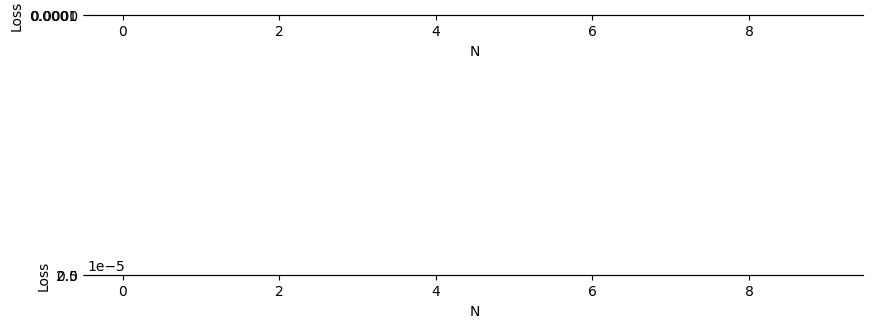

In [30]:
optimise_network(x_data, y_data, 0.25, 10, 1, [], False, "double_layer_train_and_test_loss_vs_neuron.pdf")

In [ ]:
hidden_layer = [29]
train_test_split_value = 0.01
save_filepath = 'test_model.pth'

model = sklearn_model_generation(train_test_split_value, hidden_layer, x_data, y_data)
save_model(x_data, y_data, hidden_layer, model, ANN, save_filepath)